In [1]:
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
from tqdm import tqdm

# use seaborn plotting defaults
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog

In [2]:
#директории train и test датасетов
dirname_train = "F:\Programming\_Projects\Start_ML_HSE\Competition\ML_track_train"
dirname_test = "F:\Programming\_Projects\Start_ML_HSE\Competition\ML_track_test"

Тренировочный датасет довольно маленький по сравнению с тестовым, поэтому мы используем агументацию изображений (варьируем поворот и смещение, яркость и контраст, отражение по горизонтали). В тестовом датасете также присутствуют зашумленные фотографии, поэтому добавляем Гауссовский шум, его интенсивность подбиралась опытынм путем (параметр var_limit). 

In [3]:
import random
import albumentations as A

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

def get_aug(image):
    angle = np.arange(-10,11,1)
    angle0 = random.choice(angle)

    shift = 0.01*np.arange(-10,11,1)
    shift0 = random.choice(shift)

    transform = A.Compose([
    A.ShiftScaleRotate(shift_limit=[shift0,shift0], scale_limit=0, 
                        rotate_limit=[angle0,angle0], p=0.5),
    A.HorizontalFlip(p=0.5),
    A.PiecewiseAffine(p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.3),
    A.GaussNoise(var_limit=(10,250), p=0.5)
    ])
    return transform(image=image)['image']

1. Загрузка и обработка данных

Загрузка тренировочных данных и применение каскадов Хаара для детекции лиц на фотографиях.
Оказалось, что точность предсказаний повышается при детекции лиц на уже аугментированных и увеличенных фотографиях

In [4]:
X_train, y_train, X_train3 = [], [], []

X_train_Aug, y_train_Aug = [], []
no_face = 0
filelist = os.listdir(dirname_train)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')

for fname in filelist:
    img = cv2.imread(os.path.join(dirname_train, fname), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)
    X_train.append(img)
    y_train.append(int(fname.split('label')[1].split('.png')[0]))

for (a,b) in zip(X_train,y_train):
    for i in range(4):
        X_train3.append(get_aug(a))
        y_train_Aug.append(b)

for img in X_train3:    
    face = face_cascade.detectMultiScale(img)
    
    for (a, b, w, h) in face:
        cv2.rectangle(img, (a, b), (a+w, b+h), (0, 0, 255), 2)
        face = img[b:b + h, a:a + w]

    try:
        h, w = face.shape
        size = min(h, w)
        h0 = int((h - size) / 2)
        w0 = int((w - size) / 2)
            
        img = face[h0: h0 + size, w0: w0 + size]        

    except:
        no_face+=1

    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)    
    X_train_Aug.append(img)
    

print(no_face,'faces were not found')

len(X_train_Aug), len(y_train_Aug)

181 faces were not found


(1252, 1252)

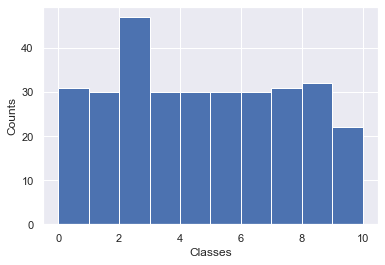

In [5]:
bins = np.arange(0, 11, 1) 

plt.hist(y_train, bins=bins, alpha=1)
plt.xlabel('Classes')
plt.ylabel('Counts')

plt.show()

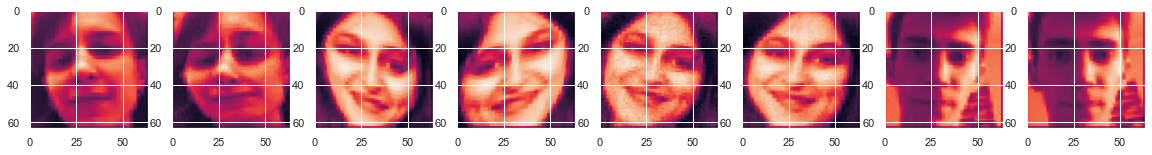

In [6]:
fig, axx = plt.subplots(1, 8, figsize=(20, 10))

for i in range(8):
    img = X_train_Aug[i+62]
    axx[i].imshow(img)

Загрузка тестовых данных. Тестовые изображения загружаются в произвольном порядке, поэтому сделаем сортировку по номерам, указанным в названиях изображений.
Тестовый датасет мы не аугментируем, но перед детекцией лиц делаем rescale до (256, 256), а обрезанные прямоугольники с лицами снова уменьшаем до (64, 64) 

In [7]:
def sort_by_index(fname):
    return int(fname.split('.')[0].split('image')[1])

In [8]:
X_test = []
Names = []
no_face = 0

for fname in tqdm(sorted(os.listdir(dirname_test), key=sort_by_index)):
    img = cv2.imread(os.path.join(dirname_test, fname), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA) 
    Names.append(fname)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')
    face = face_cascade.detectMultiScale(img)
    
    for (a, b, w, h) in face:
        cv2.rectangle(img, (a, b), (a+w, b+h), (0, 0, 255), 2)
        face = img[b:b + h, a:a + w]

    try:
        h, w = face.shape
        size = min(h, w)
        h0 = int((h - size) / 2)
        w0 = int((w - size) / 2)
            
        img = face[h0: h0 + size, w0: w0 + size]
              
    except:
        no_face+=1
    
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)
    X_test.append(img)
    
print(no_face,'faces were not found')
len(X_test)

100%|██████████| 2090/2090 [01:48<00:00, 19.29it/s]

247 faces were not found


2090

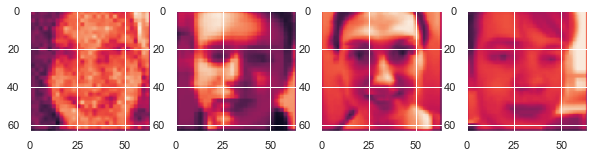

In [9]:
fig, axx = plt.subplots(1, 4, figsize=(10, 5))

for i in range(4):
    img = X_test[i+90]
    axx[i].imshow(img)

Признаки для классификации извлекаем с помощью метода HOG. Изменение параметров преобразования на практике не дало прироста в точности.

In [10]:
hog_img_train = []
for i in range(len(X_train_Aug)):
    fd, hog_image = hog(X_train_Aug[i], orientations=8, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True)
    hog_img_train.append(hog_image)

In [11]:
hog_img_test = []
for i in range(len(X_test)):
    fd, hog_image = hog(X_test[i], orientations=8, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True)
    hog_img_test.append(hog_image)

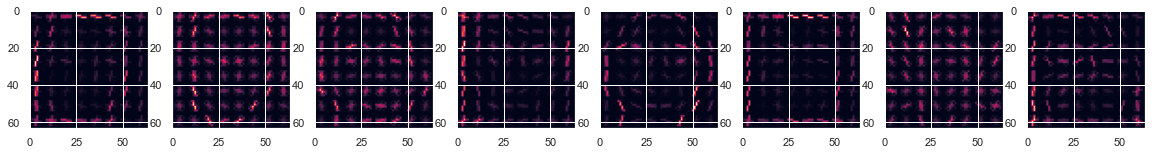

In [12]:
fig, axx = plt.subplots(1, 8, figsize=(20, 10))

for i in range(8):
    img = hog_img_test[i+45]
    axx[i].imshow(img)

2. Обучение модели и подбор гиперпараметров

In [13]:
X_train_flatten = np.array([el.ravel() for el in hog_img_train])
X_test_flatten = np.array([el.ravel() for el in hog_img_test])

Точность модели буду оценивать на отложенной валидационной выборке

In [14]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train_flatten, y_train_Aug, stratify=y_train_Aug, random_state=1)

Для уменьшения размерности пространства признаков мы используем метод главных компонент. Число компонент можно примерно оценить по правилу Кайзера, чтобы при данном числе компонент доля объясненной дисперсии составляла 95%. Перед PCA данные необходимо отнормировать. Я пробовала MinMaxScaler и StandardScaler, последний показал себя чуть лучше.
Также для уменьшения размерности я пробовала LinearDiscriminantAnalysis, но прироста в точности этот метод не дал  

Text(0, 0.5, 'cumulative explained variance')

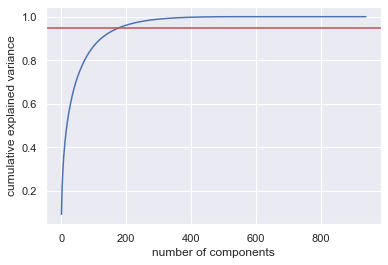

In [15]:
pca = PCA().fit(X_tr, y_tr)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=0.95, color='r', linestyle='-')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [16]:
scl = StandardScaler()
pca = KernelPCA()
model_svm = SVC(probability=True)

pipe = Pipeline(steps=[('scl', scl), ('pca', pca), ('svm', model_svm)])

param_grid = {
    "pca__n_components": [130, 150, 170],
    "pca__kernel": ['linear'],
    'svm__C': [3, 5, 7],
    'svm__kernel': ['rbf', 'linear'],
}

grid = GridSearchCV(estimator = pipe, param_grid = param_grid, 
                           scoring = 'accuracy', cv = 10, 
                           n_jobs = -1, verbose = 2)

grid.fit(X_tr, y_tr)

print(f"best mean cross-validation score: {grid.best_score_}")
print(f"best parameters: {grid.best_params_}")
print(f"val-set score: {grid.score(X_val, y_val):.3f}")

Fitting 10 folds for each of 18 candidates, totalling 180 fits
best mean cross-validation score: 0.8743422557767101
best parameters: {'pca__kernel': 'linear', 'pca__n_components': 130, 'svm__C': 5, 'svm__kernel': 'rbf'}
val-set score: 0.914


In [17]:
grid.best_estimator_.fit(X_train_flatten, y_train_Aug)
probas = grid.best_estimator_.predict_proba(X_test_flatten)
pred = probas.argmax(1)
max_probas = [max(el) for el in probas]
pred_df = pd.DataFrame(list(zip(Names, pred)), columns = ['img_name', 'pred_class'])
pred_df.head()

,img_name,pred_class
0,image0.png,7
1,image1.png,3
2,image2.png,4
3,image3.png,5
4,image4.png,0


Посмотрим, с какой вероятностью модель делает предсказания. Как мы видим, довольно большой хвост объектов, где модель не уверена

<AxesSubplot:>

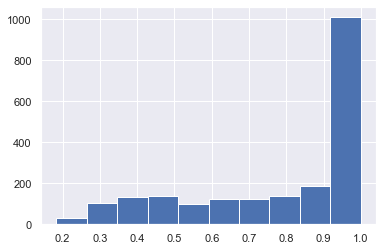

In [18]:
pred_df['proba'] = max_probas
pred_df['proba'].hist()

При обработке данных на части фотографий не удалось распознать лица. Чтобы классифицировать такие фото я отдельно сформировала предсказания с помощью аналогичной модели на необрезанных фотографиях. И для тех объектов, где основная модель не очень уверена (опытным путем я определила порог в 0.4), я заменяю предсказания на результаты второй модели.  

In [19]:
pred_no_haar = pd.read_csv('submission_no_haar.csv', header=0)
results = pd.concat([pred_df,pred_no_haar], axis = 1)

In [20]:
results['pred_class'] = np.where(results['proba'] < 0.4, 
                                    results['pred_class_no_haar'], results['pred_class'])
pred_df = results.drop(['proba', 'img_name_no_haar', 'pred_class_no_haar'], axis=1)
pred_df.to_csv("submission_svm_best.csv", index=False)
pred_df.head()

,img_name,pred_class
0,image0.png,7
1,image1.png,3
2,image2.png,4
3,image3.png,5
4,image4.png,0
